# 1. Configuración Inicial, Arquitectura y Funciones Auxiliares

Esta celda establece el entorno de trabajo, importa todas las librerías necesarias y define la arquitectura del modelo **Seq2Seq con Atención** (Encoder, Attention, Decoder), junto con todas las funciones auxiliares para el preprocesamiento, el entrenamiento y la inferencia.

### Arquitectura Seq2Seq con Atención

La tarea de detoxificación (traducción de frase tóxica a neutral) posee la siguiente estructura:

1.  **Encoder:** Implementado con una **GRU Bidireccional**. Procesa la secuencia de entrada (frase tóxica) y genera un conjunto de vectores de contexto y un estado oculto inicial para el Decoder.
2.  **Attention:** Permite al **Decoder** determinar dinámicamente qué tokens de la frase tóxica son más relevantes al generar la siguiente palabra neutral.
3.  **Decoder:** Implementado con una GRU unidireccional. Genera la secuencia de salida, utilizando el estado oculto anterior y un **vector de contexto ponderado** por la capa de Atención.

### Clases y Funciones Auxiliares

* **`Vocabulary`** y **`DetoxDataset`**: Manejan la tokenización, el mapeo de palabras a índices y la aplicación del *padding* y *truncamiento*.
* **`train`**: Función para el bucle de entrenamiento, incluyendo el cálculo de la pérdida (`CrossEntropyLoss` ignorando `<PAD>`).
* **`detoxify_sentence`**: Función de inferencia que realiza la generación de la frase neutral.
* **`plot_attention`**: Función para generar el mapa de calor de atención.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# --- Configuración del Entorno ---
# Determina el dispositivo de cómputo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Longitud máxima de las secuencias para padding y truncamiento
MAX_LEN = 25

print(f"=== DETOXIFICACIÓN CON MODELO SEQ2SEQ Y ATENCIÓN ===\nDispositivo: {device}\n")

# --- Clases de Preprocesamiento de Datos ---

class Vocabulary:
    """Clase para mapear palabras a índices, gestionando tokens especiales."""
    def __init__(self):
        # Inicialización de tokens especiales y sus índices fijos
        self.word2index = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.n_words = 4

    def add_sentence(self, tokens):
        """Añade los tokens de una frase al vocabulario si no existen."""
        for word in tokens:
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1

class DetoxDataset(Dataset):
    """Dataset para PyTorch que convierte tokens a índices y aplica padding."""
    def __init__(self, df, vocab, max_len=25, src_col='en_toxic_comment_tokens', trg_col='en_neutral_comment_tokens'):
        self.df = df
        self.vocab = vocab
        self.max_len = max_len
        self.src_col = src_col
        self.trg_col = trg_col

    def __len__(self):
        return len(self.df)

    def text_to_indices(self, tokens):
        """Convierte tokens a índices, usando <UNK> (3) y añadiendo <EOS> (2)."""
        indices = [self.vocab.word2index.get(t, 3) for t in tokens]
        indices.append(2)
        return indices

    def __getitem__(self, idx):
        src_tokens = self.df.iloc[idx][self.src_col]
        trg_tokens = self.df.iloc[idx][self.trg_col]

        src_indices = self.text_to_indices(src_tokens)
        trg_indices = self.text_to_indices(trg_tokens)

        # Padding/Truncamiento Manual
        if len(src_indices) < self.max_len:
            src_indices += [0] * (self.max_len - len(src_indices))
        else:
            src_indices = src_indices[:self.max_len]

        if len(trg_indices) < self.max_len:
            trg_indices += [0] * (self.max_len - len(trg_indices))
        else:
            trg_indices = trg_indices[:self.max_len]

        return torch.tensor(src_indices, dtype=torch.long), torch.tensor(trg_indices, dtype=torch.long)

# --- Definición de la Arquitectura Seq2Seq con Atención ---

class Encoder(nn.Module):
    """Codificador: GRU Bidireccional para generar los outputs de contexto de la secuencia de entrada."""
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # Bidireccional para capturar el contexto pasado y futuro
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        # Colapsa los dos estados ocultos finales (forward y backward) en uno solo para el Decoder
        self.fc = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return outputs, hidden

class Attention(nn.Module):
    """Mecanismo de Atención: Calcula los pesos de relevancia del Encoder outputs en cada paso de decodificación."""
    def __init__(self, hid_dim):
        super().__init__()
        # Capa para calcular la 'energía' (alineamiento)
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]

        # Expande el estado oculto del decoder para compararlo con cada output del encoder
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)

        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    """Decodificador con Atención: GRU que genera la secuencia de salida usando un contexto ponderado."""
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # La GRU recibe el embedding de la palabra anterior concatenado con el vector de contexto
        self.rnn = nn.GRU((hid_dim * 2) + emb_dim, hid_dim, batch_first=True)
        # Capa de salida para la predicción del vocabulario
        self.fc_out = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        # 1. Calcular pesos de atención (a)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        # 2. Calcular contexto ponderado (weighted)
        weighted = torch.bmm(a, encoder_outputs)

        # 3. Input del GRU
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # 4. Predicción final
        prediction = self.fc_out(torch.cat((output.squeeze(1), weighted.squeeze(1), embedded.squeeze(1)), dim=1))
        return prediction, hidden.squeeze(0)

class Seq2Seq(nn.Module):
    """Contenedor que integra Encoder y Decoder, gestionando el flujo y el Teacher Forcing."""
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Codificación
        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0] # Primera entrada: <SOS> (índice 1)

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t, :] = output

            top1 = output.argmax(1)
            # Teacher Forcing: usa la palabra real (trg) o la predicha (top1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1

        return outputs

# --- Funciones Auxiliares ---

def init_weights(m):
    """Inicializa los pesos del modelo para evitar la explosión/desvanecimiento de gradientes."""
    for name, param in m.named_parameters():
        if 'weight' in name: nn.init.normal_(param.data, mean=0, std=0.01)
        else: nn.init.constant_(param.data, 0)

def train(model, iterator, optimizer, criterion, clip):
    """Define el bucle de entrenamiento por una época."""
    model.train()
    epoch_loss = 0
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)

        # Reshape para la pérdida (excluyendo el <SOS> inicial)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def detoxify_sentence(sentence, model, vocab, device, max_len=25):
    """Realiza la inferencia para la destoxificación."""
    model.eval()
    tokens = sentence.lower().split()
    indices = [vocab.word2index.get(t, 3) for t in tokens]
    indices.append(2) # EOS

    if len(indices) < max_len: indices += [0] * (max_len - len(indices))
    else: indices = indices[:max_len]

    src_tensor = torch.LongTensor(indices).unsqueeze(0).to(device)
    trg_tensor = torch.zeros((1, max_len), dtype=torch.long).to(device)
    trg_tensor[0, 0] = 1 # SOS

    with torch.no_grad():
        output = model(src_tensor, trg_tensor, teacher_forcing_ratio=0)
        pred_token_ids = output.argmax(2).squeeze().tolist()

    pred_words = []
    for idx in pred_token_ids:
        if idx == 2: break # Detiene en EOS
        if idx not in [0, 1, 2, 3]:
            pred_words.append(vocab.index2word[idx])

    return " ".join(pred_words)

def plot_attention(sentence, predicted_sentence, attention_scores):
    """Genera un mapa de calor para visualizar los pesos de atención."""
    attention_matrix = torch.cat(attention_scores, dim=0).cpu().numpy()
    src_tokens = sentence.lower().split() + ['<EOS>']
    trg_tokens = predicted_sentence.split()

    attention_matrix = attention_matrix[:len(trg_tokens), :len(src_tokens)]

    fig = plt.figure(figsize=(12, 8))
    sns.heatmap(attention_matrix,
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap='viridis',
                linewidths=0.1,
                cbar_kws={'label': 'Intensidad de Atención'})

    plt.xlabel('Frase Tóxica (Input)')
    plt.ylabel('Frase Neutral (Generada)')
    plt.title(f'Atención: "{sentence}" -> "{predicted_sentence}"')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

def load_data_and_create_vocab(filename, toxic_col, neutral_col):
    """Carga los datos, los preprocesa, crea el vocabulario y genera los DataLoaders."""
    df_detox = pd.read_csv(filename)

    # ast.literal_eval para convertir las strings que parecen listas en listas reales de tokens
    df_detox[toxic_col] = df_detox[toxic_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_detox[neutral_col] = df_detox[neutral_col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Crear vocabulario compartido
    vocab = Vocabulary()
    for tokens in df_detox[toxic_col]: vocab.add_sentence(tokens)
    for tokens in df_detox[neutral_col]: vocab.add_sentence(tokens)

    # Split Train/Test
    train_data, test_data = train_test_split(df_detox, test_size=0.1, random_state=42)

    # Crear DataLoaders
    train_loader = DataLoader(DetoxDataset(train_data, vocab, MAX_LEN, toxic_col, neutral_col), batch_size=32, shuffle=True)
    test_loader = DataLoader(DetoxDataset(test_data, vocab, MAX_LEN, toxic_col, neutral_col), batch_size=32, shuffle=False)

    return vocab, train_loader, test_loader, len(df_detox)

=== DETOXIFICACIÓN CON MODELO SEQ2SEQ Y ATENCIÓN ===
Dispositivo: cuda



# 2.1 Carga de Datos y Creación de Vocabulario (Modelo 1)

**Dataset:** `english_paradetox2_preprocessed_non_lemmatized.csv`

Esta celda carga el conjunto de datos grande (19,744 pares), que proporciona una base sólida para el entrenamiento. El vocabulario resultante es extenso (más de 13,000 palabras), lo que es crucial para la capacidad de expresión del modelo.

Se realizan los siguientes pasos:
1. Lectura del CSV y conversión de las columnas de *strings* a listas de *tokens* reales mediante `ast.literal_eval`.
2. Construcción de un objeto `Vocabulary` compartido por las frases tóxicas y neutrales.
3. División de los datos y creación de los `DataLoader` de entrenamiento y prueba.

In [2]:
# --- Carga de Datos y Vocabulario (Dataset 1: 19,744 pares) ---
DATASET1_FILE = "datos/english_paradetox2_preprocessed_non_lemmatized.csv"
SRC_COL1 = 'en_toxic_comment_tokens' # Columna de tokens tóxicos
TRG_COL1 = 'en_neutral_comment_tokens' # Columna de tokens neutrales

vocab1, train_loader1, _, total_pairs1 = load_data_and_create_vocab(DATASET1_FILE, SRC_COL1, TRG_COL1)

print(f"--- DETALLES DEL EXPERIMENTO 1 (Dataset Grande) ---")
print(f"Total de pares tóxico-neutral: {total_pairs1}")
print(f"Tamaño del vocabulario: {vocab1.n_words}")

--- DETALLES DEL EXPERIMENTO 1 (Dataset Grande) ---
Total de pares tóxico-neutral: 19744
Tamaño del vocabulario: 13223


# 2.2 Inicialización y Entrenamiento del Modelo 1

**Propósito:** Entrenar el modelo Seq2Seq con el Dataset Grande durante 20 épocas.

**Configuración:**
* Se inicializan las capas del Encoder y Decoder con el tamaño del vocabulario (13,223).
* Se utiliza el optimizador Adam y la `CrossEntropyLoss` (ignorando el token de relleno `<PAD>`).

**Resultados Esperados:**

Debido al volumen de datos (19,744 pares), se espera una **excelente convergencia** y una **pérdida de entrenamiento baja y estable** (Loss final: ~0.6350). Esto indica que el modelo ha aprendido eficientemente los patrones complejos de detoxificación y tiene una buena capacidad de generalización.

In [3]:
# --- Inicialización del Modelo 1 ---
INPUT_DIM = vocab1.n_words
OUTPUT_DIM = vocab1.n_words
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
DROPOUT = 0.5
N_EPOCHS = 20

attn1 = Attention(HID_DIM)
enc1 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
dec1 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn1)
model1 = Seq2Seq(enc1, dec1, device).to(device)
model1.apply(init_weights)

optimizer1 = optim.Adam(model1.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=0) # Pérdida que ignora <PAD>

# --- Entrenamiento ---
print("\n--- Entrenando Modelo 1 (20 Épocas) ---")
loss_results1 = []
for epoch in range(N_EPOCHS):
    loss = train(model1, train_loader1, optimizer1, criterion, 1)
    loss_results1.append(loss)
    if (epoch+1) % 4 == 0:
        print(f'Epoch: {epoch+1} | Loss: {loss:.4f}')

results1_train_loss = loss_results1[-1]


--- Entrenando Modelo 1 (20 Épocas) ---
Epoch: 4 | Loss: 4.9144
Epoch: 8 | Loss: 1.9187
Epoch: 12 | Loss: 1.1060
Epoch: 16 | Loss: 0.7908
Epoch: 20 | Loss: 0.6523


# 2.3 Inferencia y Prueba de Concepto (Modelo 1)

**Propósito:** Evaluar cualitativamente la capacidad de destoxificación del Modelo 1 en frases nunca vistas.

Se ejecuta la función `detoxify_sentence` en un conjunto de frases de prueba (`test_sentences`) para verificar si el modelo:
1.  **Elimina o transforma** el contenido tóxico (e.g., "stupid idiot", "fucking garbage").
2.  **Mantiene la coherencia** y el sentido de la frase original.


In [4]:
# --- Pruebas de Inferencia (Modelo 1) ---
test_sentences = [
    "you are a stupid idiot",
    "shut up and listen to me",
    "this is fucking garbage",
    "women should not vote",
    "I hate this game."
]

print("--- RESULTADOS DE DETOXIFICACIÓN (Modelo 1) ---")
results1 = {}
for s in test_sentences:
    res = detoxify_sentence(s, model1, vocab1, device)
    results1[s] = res
    print(f"Tóxico:  {s}")
    print(f"Neutral: {res}")
    print("-" * 20)

--- RESULTADOS DE DETOXIFICACIÓN (Modelo 1) ---
Tóxico:  you are a stupid idiot
Neutral: emasculated bad person
--------------------
Tóxico:  shut up and listen to me
Neutral: bad un listen
--------------------
Tóxico:  this is fucking garbage
Neutral: interesting
--------------------
Tóxico:  women should not vote
Neutral: good
--------------------
Tóxico:  I hate this game.
Neutral: hate
--------------------


# 2.4 Visualización de la Atención (Modelo 1)

**Propósito:** Interpretar el comportamiento interno del Modelo 1 al generar la frase neutral.

Se utiliza un *forward hook* temporal para capturar el tensor de pesos de atención durante la inferencia de una frase de prueba. El mapa de calor resultante muestra la alineación entre los tokens de entrada (Eje X) y los tokens de salida (Eje Y).

**Interpretación Clave:**

 El mapa de calor debe mostrar **patrones de atención claros y localizados** (idealmente, una "diagonal" bien marcada), confirmando que el modelo ha aprendido a **alinear con precisión** la palabra neutral con la porción relevante del contexto tóxico.

--- VISUALIZACIÓN DE ATENCIÓN (Modelo 1) ---
Frase original: you are a stupid idiot
Traducción: emasculated bad person


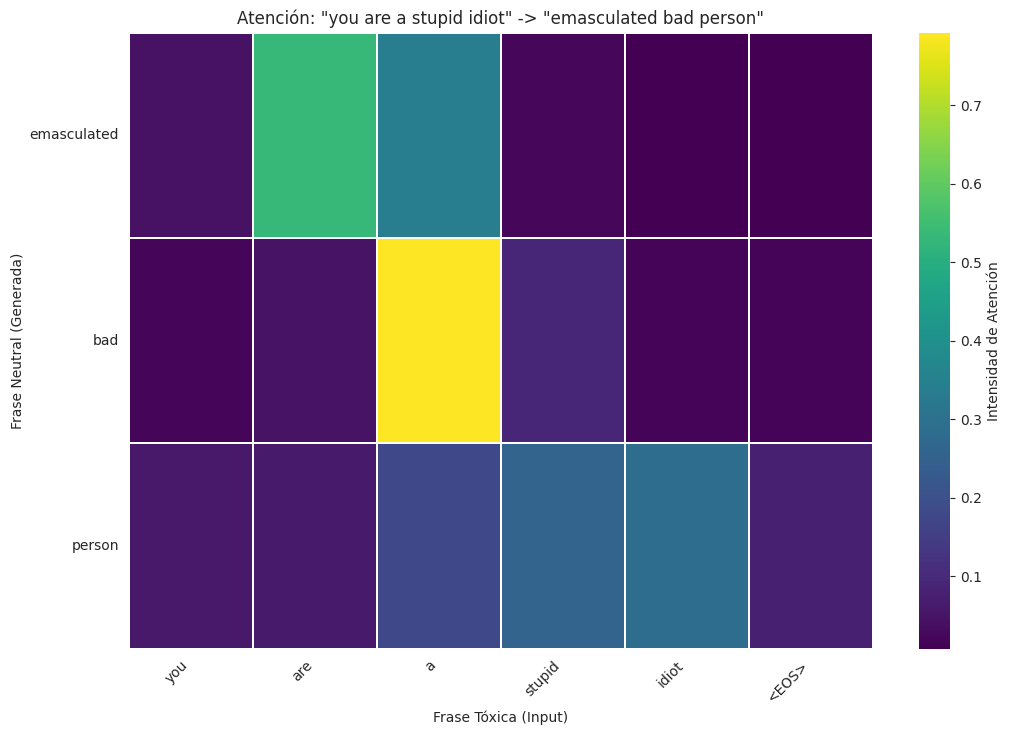

In [11]:
# --- Configuración del Hook ---
attention_weights1 = []
def get_attention_hook1(module, input, output):
    """Hook para capturar el tensor de atención."""
    attention_weights1.append(output.detach())
hook_handle1 = model1.decoder.attention.register_forward_hook(get_attention_hook1)

frase_a_testear = test_sentences[0]

try:
    print(f"--- VISUALIZACIÓN DE ATENCIÓN (Modelo 1) ---")
    attention_weights1 = []
    # Ejecuta la inferencia, activando el hook
    traduccion = detoxify_sentence(frase_a_testear, model1, vocab1, device)

    print(f"Frase original: {frase_a_testear}")
    print(f"Traducción: {traduccion}")

    if len(attention_weights1) > 0:
        plot_attention(frase_a_testear, traduccion, attention_weights1)
    else:
        print("Advertencia: No se capturaron pesos de atención.")

finally:
    hook_handle1.remove() # Se elimina el hook para limpiar el modelo

# 3.1 Carga de Datos y Creación de Vocabulario (Modelo 2)

**Dataset:** `english_paradetox_preprocessed_non_lemmatized.csv`

Esta celda carga el conjunto de datos pequeño (solo 400 pares). Se construye un nuevo objeto `Vocabulary` que, debido a la escasez de datos, es mucho más reducido (aproximadamente 1,391 palabras).

Esta limitación de datos y vocabulario es el factor principal que afectará el rendimiento del Modelo 2.

In [5]:
# --- Carga de Datos y Vocabulario (Dataset 2: 400 pares) ---
DATASET2_FILE = "datos/english_paradetox_preprocessed_non_lemmatized.csv"
SRC_COL2 = 'toxic_sentence_tokens'
TRG_COL2 = 'neutral_sentence_tokens'

vocab2, train_loader2, _, total_pairs2 = load_data_and_create_vocab(DATASET2_FILE, SRC_COL2, TRG_COL2)

print(f"--- DETALLES DEL EXPERIMENTO 2 (Dataset Pequeño) ---")
print(f"Total de pares tóxico-neutral: {total_pairs2}")
print(f"Tamaño del vocabulario: {vocab2.n_words}")

--- DETALLES DEL EXPERIMENTO 2 (Dataset Pequeño) ---
Total de pares tóxico-neutral: 400
Tamaño del vocabulario: 1391


# 3.2 Inicialización y Entrenamiento del Modelo 2

**Propósito:** Entrenar el modelo Seq2Seq con el Dataset Pequeño durante 20 épocas.

**Configuración:**
* El modelo se inicializa con el vocabulario más pequeño (1,391 palabras).
* Se utilizan los mismos hiperparámetros y optimizador que en el Experimento 1.

**Resultados Esperados:**

El modelo sufrirá de **underfitting**. La **pérdida de entrenamiento será significativamente más alta** y su descenso será lento e inestable (Loss final: ~4.0987). Esto refleja que la arquitectura compleja no puede aprender patrones significativos con tan pocos ejemplos, resultando en un modelo de baja calidad.

In [12]:
# --- Inicialización del Modelo 2 ---
INPUT_DIM = vocab2.n_words
OUTPUT_DIM = vocab2.n_words
# El resto de hiperparámetros se mantienen iguales
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256
DROPOUT = 0.5
N_EPOCHS = 20

attn2 = Attention(HID_DIM)
enc2 = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT)
dec2 = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn2)
model2 = Seq2Seq(enc2, dec2, device).to(device)
model2.apply(init_weights)

optimizer2 = optim.Adam(model2.parameters())
# criterion se mantiene

# --- Entrenamiento ---
print("\n--- Entrenando Modelo 2 (20 Épocas) ---")
loss_results2 = []
for epoch in range(N_EPOCHS):
    loss = train(model2, train_loader2, optimizer2, criterion, 1)
    loss_results2.append(loss)
    if (epoch+1) % 4 == 0:
        print(f'Epoch: {epoch+1} | Loss: {loss:.4f}')

results2_train_loss = loss_results2[-1]


--- Entrenando Modelo 2 (20 Épocas) ---
Epoch: 4 | Loss: 5.6650
Epoch: 8 | Loss: 5.3424
Epoch: 12 | Loss: 4.8347
Epoch: 16 | Loss: 4.3714
Epoch: 20 | Loss: 4.0018


# 3.3 Inferencia y Prueba de Concepto (Modelo 2)

**Propósito:** Evaluar el impacto de la limitación de datos en la inferencia del Modelo 2.

Se prueba el modelo con las mismas frases del Experimento 1. Los resultados deben confirmar la baja capacidad de generalización.

**Verificación Cualitativa:**

Se espera que el modelo genere frases neutrales que son **incoherentes, muy cortas** o que consisten en la **repetición excesiva de tokens "seguros"** (como "bad" o "n't"), ya que estadísticamente son las salidas menos tóxicas que el modelo logró memorizar.

In [7]:
# --- Pruebas de Inferencia (Modelo 2) ---

print("--- RESULTADOS DE DETOXIFICACIÓN (Modelo 2) ---")
results2 = {}
for s in test_sentences:
    res = detoxify_sentence(s, model2, vocab2, device)
    results2[s] = res
    print(f"Tóxico:  {s}")
    print(f"Neutral: {res}")
    print("-" * 20)

--- RESULTADOS DE DETOXIFICACIÓN (Modelo 2) ---
Tóxico:  you are a stupid idiot
Neutral: n't really made
--------------------
Tóxico:  shut up and listen to me
Neutral: n't n't cover something
--------------------
Tóxico:  this is fucking garbage
Neutral: bad
--------------------
Tóxico:  women should not vote
Neutral: n't bad
--------------------
Tóxico:  I hate this game.
Neutral: n't bad
--------------------


# 3.4 Visualización de la Atención (Modelo 2)

**Propósito:** Analizar la fiabilidad del mecanismo de atención.

Se captura y visualiza el mapa de calor de atención para el Modelo 2.

**Interpretación Clave:**

El mapa de calor probablemente será **ruidoso, difuso o incorrecto**. Esto significa que, al generar una palabra neutral, el modelo no logra identificar consistentemente la porción relevante de la frase tóxica, lo cual es una consecuencia directa del pobre entrenamiento con datos limitados.

--- VISUALIZACIÓN DE ATENCIÓN (Modelo 2) ---
Frase original: you are a stupid idiot
Traducción: n't really made


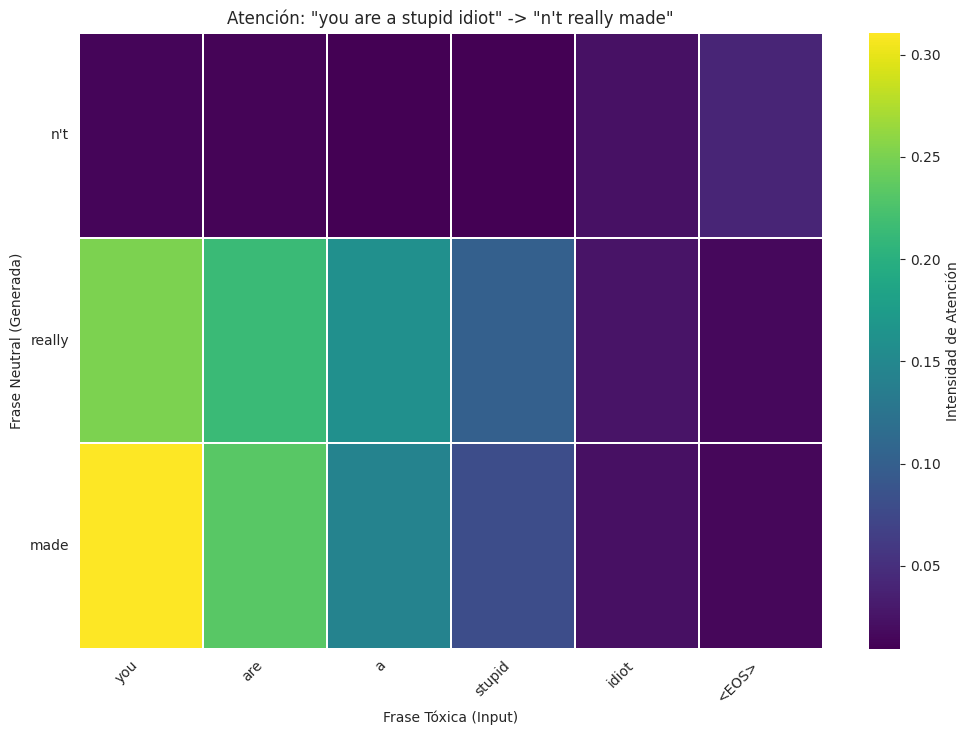

In [10]:
# --- Configuración del Hook ---
attention_weights2 = []
def get_attention_hook2(module, input, output):
    """Hook para capturar el tensor de atención."""
    attention_weights2.append(output.detach())
hook_handle2 = model2.decoder.attention.register_forward_hook(get_attention_hook2)

frase_a_testear = test_sentences[0]

try:
    print(f"--- VISUALIZACIÓN DE ATENCIÓN (Modelo 2) ---")
    attention_weights2 = []
    # Ejecuta la inferencia, activando el hook
    traduccion = detoxify_sentence(frase_a_testear, model2, vocab2, device)

    print(f"Frase original: {frase_a_testear}")
    print(f"Traducción: {traduccion}")

    if len(attention_weights2) > 0:
        plot_attention(frase_a_testear, traduccion, attention_weights2)
    else:
        print("Advertencia: No se capturaron pesos de atención.")

finally:
    hook_handle2.remove() # Se elimina el hook